# Imports

In [ ]:
#Useful Packages
!pip3 install datasets > /dev/null 2>&1
%pip install -qq tensorflow
import datasets
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
import math
import nltk
import sklearn
from sklearn import preprocessing
from abc import ABC, abstractmethod
from numpy.core.memmap import dtype
from zmq import NULL
from google.colab import data_table
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from typing import List
from tqdm import tqdm

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

# Task 1

In [ ]:
def normalization (data):
  data_mean = data.mean(axis=0, dtype=np.float64)
  #print("data_mean_shape ", data_mean.shape)
  data_dot = data - data_mean
  data_std = np.std(data, axis=0, dtype=np.float64)
  data_tildy = np.divide(data_dot, data_std)
  return data_tildy.astype(np.float128)

In [ ]:
# Image conversions 

def to_vector(image):
  return np.array([pixel for row in np.array(image) for pixel in row])

# Constructing a matrix where each row is 1 image from the dataset
def to_matrix(images):
  return np.array([to_vector(image) for image in images], dtype=np.float64)

In [ ]:
# Fashion-MNIST with duplicates removed
dataset = datasets.load_dataset("fashion_mnist")
train = dataset.get("train")
test = dataset.get("test")
X_train = to_matrix([train[i].get("image") for i in range(len(train))])
X_test = to_matrix([test[i].get("image") for i in range(len(test))])
y_train = np.array([train[i].get("label") for i in range(len(train))])
y_test = np.array([test[i].get("label") for i in range(len(test))])

# Saving non-normalized date
X_train_unnorm = X_train
X_test_unnorm  = X_test


# Normalizing data
X_train = normalization(X_train)
X_test = normalization(X_test)
#y_train = normalization(y_train)
#y_test = normalization(y_test)

print(X_train.shape)
print(X_test.shape)

Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

(60000, 784)
(10000, 784)


In [ ]:
print(np.amax(y_train)) # 10 (0 to 9) articles of clothing
print(X_train.shape)

9
(60000, 784)


In [ ]:
# Mini Batching
def minibatch (data, batch_size):
  num_data_points = data.shape[0]
  indices = np.random.choice(num_data_points, batch_size)
  batch = data[indices,:]
  return batch, indices

In [ ]:
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

<ipython-input-9-d3cfb8de8020>:13: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  plt.savefig("data", bbox_inches="tight", dpi=300)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


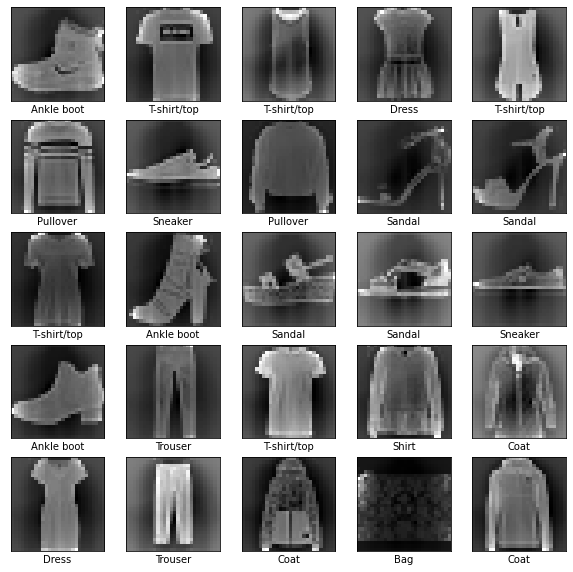

In [ ]:
plt.figure(figsize=(10, 10))

rows = 5
columns = 5
for i in range(rows*columns):

  plt.subplot(rows, columns, i+1)
  plt.imshow(X_train[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
  plt.xlabel(class_labels[y_train[i]])
  plt.yticks([])
  plt.xticks([])

plt.savefig("data", bbox_inches="tight", dpi=300)
plt.show()

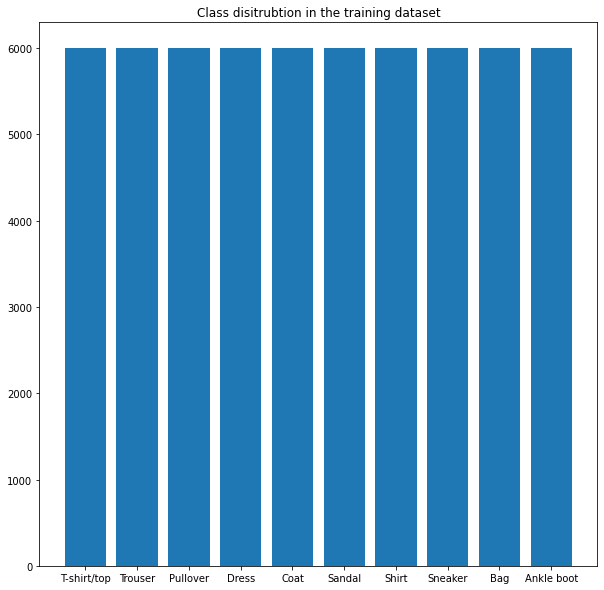

In [ ]:
plt.figure(figsize=(10, 10))

_, counts = np.unique(y_train, return_counts=True)
plt.bar(class_labels, counts, align='center')
plt.title("Class disitrubtion in the training dataset")
plt.savefig("trainin-data", bbox_inches="tight", dpi=300)
plt.show()

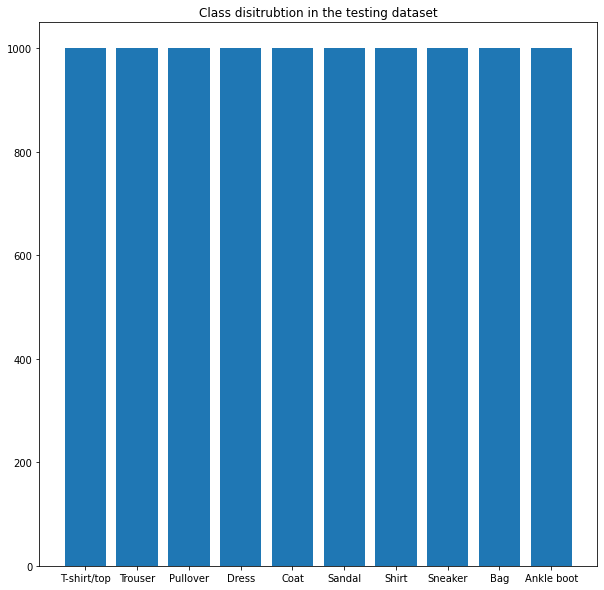

In [ ]:
plt.figure(figsize=(10, 10))

_, counts = np.unique(y_test, return_counts=True)
plt.bar(class_labels, counts, align='center')
plt.title("Class disitrubtion in the testing dataset")
plt.savefig("testing-data", bbox_inches="tight", dpi=300)
plt.show()

# Task 2

Neural Net Layer

In [ ]:
class NeuralNetLayer:
    def __init__(self, input_size, output_size):
        self.gradient = None
        self.parameters = None
        self.input_size = input_size
        self.output_size = output_size
        self.input = None
        self.output = None
        
    def forward_impl(self, x): #Wrapping the forward function
        raise NotImplementedError

    def backward_impl(self, gradient): #Wrapping the backward function
        raise NotImplementedError
    
    def forward(self, x):
        self.input = x
        result = self.forward_impl(self.input)
        self.output = result
        return result
    
    def backward(self, gradient):
        result = self.backward_impl(gradient)
        return result
    
    def is_linear_layer(self):
        raise NotImplementedError

Linear Layer

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__(input_size, output_size)
        self.w = np.random.randn(output_size, input_size)/10
        self.b = np.random.randn(output_size)/10
        self.parameters = [self.w, self.b]

    def forward_impl(self, x):
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b
        #return (self.w[None, :, :] @ x[:, :, None]) + self.b ISSUE WITH SQUEEZE FOR CHECK GRAD!!! BATCH SIZE OF 1 DOESN'T WORK
    
    def backward_impl(self, gradient): 
        dw = gradient[:, :, None] @ self.input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

    def return_w(self):
      return self.w

    def is_linear_layer(self):
      return True

ReLU Layer

In [ ]:
class ReLULayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__(input_size, output_size)
        
    def forward_impl(self, x):
      return np.maximum(0,x)

    def backward_impl(self, gradient):
        return gradient * (np.where(self.input > 0, 1.0, 0.0))

    def is_linear_layer(self):
      return False

Tanh Layer

In [ ]:
class TanhLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__(input_size, output_size)
        
    def forward_impl(self, x):
        result = np.tanh(x)
        return result

    def backward_impl(self, gradient):
        return gradient * (1.0-np.square(self.output))

    def is_linear_layer(self):
      return False

Leaky ReLU Layer

In [ ]:
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self, alpha, input_size, output_size):
        super().__init__(input_size, output_size)
        self.alpha = alpha
        
    def forward_impl(self, x):
        return np.maximum(self.alpha*x, x)

    def backward_impl(self, gradient):
        return gradient * (np.where(self.input*(self.alpha-1.0)>0.0, self.alpha*1.0, 1.0))

    def is_linear_layer(self):
      return False

Softmax Output Layer

In [ ]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__(input_size, output_size)

    def forward_impl(self, x):
        exps = np.exp(x)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        return probs

    def backward_impl(self, target):
        return self.output - target
        
    def is_linear_layer(self):
      return False

In [ ]:
class SoftmaxOutputLayer_minusMAX(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__(input_size, output_size)

    def forward_impl(self, x):
        exps = np.exp(x-np.max(x))
        probs = exps / np.sum(exps, axis=-1)[:, None]
        return probs

    def backward_impl(self, target):
        return self.output - target

    def is_linear_layer(self):
      return False

MLP CLASS

In [ ]:
class MLP:
    class Optimizer:
      def __init__(self, layers):
          self.layers = layers

      def step(self):
          for layer in self.layers[::-1]:
              if layer.parameters is not None:
                  self.update(layer.parameters, layer.gradient)

      def update(self, params, gradient):
          raise NotImplementedError

    class GradientDescentOptimizer(Optimizer):
      def __init__(self, layers, lr: float):
          super().__init__(layers)
          self.lr = lr
          self.updated_params = []

      def update(self, params, gradient):
          for (p, g) in zip(params, gradient):
              p -= self.lr * g.mean(axis=0)

          self.updated_params.append(p)
          return self.updated_params
  
  # Methods for MLP

    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)
    
    def predict(self, x):
        return np.argmax(self.forward(x),axis=1)

    def fit(self, lr, data_x, data_y, grad_steps, batch_size):
      optimizer = self.GradientDescentOptimizer(self.layers, lr) #CHANGE GRAD ALGO ONCE HERE
      losses = []
      train_acc = []
      test_acc = []
      labels = np.eye(10)[np.array(data_y)]
      for _ in tqdm(range(grad_steps)):
          batch_data_x, indices = minibatch(data_x, batch_size)
          batch_data_y = np.eye(10)[data_y[indices]]
          predictions = self.forward(batch_data_x)
          loss = -(batch_data_y * np.log(predictions)).sum(axis=-1).mean()
          losses.append(loss)
          test_batch_x, test_indices = minibatch(X_test, batch_size)          
          train_acc.append(self.evaluate_acc(data_y[indices],self.predict(batch_data_x)))         
          self.backward(batch_data_y)
          test_acc.append(self.evaluate_acc(y_test[test_indices], self.predict(test_batch_x)))         
          optimizer.step()
      
      plt.plot(losses)
      plt.xlabel("Epoch")
      plt.ylabel("Cross entropy loss")
      plt.show()

      plt.plot(train_acc, label="Train")
      plt.plot(test_acc, label="Test")
      plt.xlabel("Epoch")
      plt.ylabel("Accuracy")
      plt.legend(loc='best')
      plt.show()

    def l2_reg(self, alpha_l2=0.5):
      s = 0
      for layer in self.layers:
        if(layer.is_linear_layer()):
          s += np.linalg.norm(layer.return_w())**2
        else:
          pass
      return alpha_l2*s

    def fit_withl2_reg(self, lr, data_x, data_y, grad_steps, batch_size):
      optimizer = self.GradientDescentOptimizer(self.layers, lr) #CHANGE GRAD ALGO ONCE HERE
      losses = []
      labels = np.eye(10)[np.array(data_y)]
      for _ in tqdm(range(grad_steps)):
          batch_data_x, indices = minibatch(data_x, batch_size)
          batch_data_y = np.eye(10)[data_y[indices]]
          predictions = self.forward(batch_data_x)
          loss = -(batch_data_y * np.log(predictions)).sum(axis=-1).mean()
          l2_penalty = self.l2_reg()
          loss = loss + l2_penalty
          losses.append(loss)
          self.backward(batch_data_y)
          optimizer.step()
      plt.plot(losses)
      plt.xlabel("Epoch")
      plt.ylabel("Cross entropy loss")
    
    def grad_check(self, x):
      cumul_forward = [x]

      for layer in self.layers:
        back = cumul_forward[-1]
        cumul_forward.append(layer.forward(back))
      
      cumul_backward = [cumul_forward[-1]]

      for layer in self.layers[::-1]:
        cumul_backward.insert(0, layer.backward(cumul_backward[0]))
      
      eps = 1e-6
      f_r = cumul_forward[-1] #Final output
      for layer_index in range(len(self.layers)):
        layer = self.layers[layer_index]
        J_analytical = cumul_backward[layer_index]
        r = cumul_forward[layer_index]
        size = layer.input_size
        if (size is None):
          size = r.shape[-1]
        I = np.eye(size)*(eps)
        r_perturbed = r + I
        f_r_perturbed = r_perturbed
        for lyr in self.layers[layer_index:]:
          f_r_perturbed = lyr.forward(f_r_perturbed)
        J_approx = (f_r_perturbed - f_r)/eps

        if (np.max(np.abs(J_analytical-J_approx)) > 1e-4):
          print(f'Layer at index {layer_index} has incorrect gradient')

    def evaluate_acc(self, y_true, y_target):
      len_true = y_true.shape[0]
      len_target = y_target.shape[0]

      if len_true != len_target:
        raise Exception("True and predicted label inputs to evaluate() are not of equal length. True lable size: " + str(len_true) + "; Target lable size: " + str(len_target))

      return np.sum(y_target == y_true)/len_true

Hyperparameter

In [ ]:
def learning_rate_hyper(mlp, X_train, y_train, X_test, y_test, grad_steps): #For fixed gradient steps
  
  train_accuracies = []
  test_accuracies = []
  lrs = [0.1, 1, 10, 100, 1000]
  c = 0

  for lr in lrs:
    if (lr == 0):
      lr = 1
    mlp.fit(lr/1000, X_train, y_train, grad_steps, 128)

    y_hat = mlp.predict(X_train)
    accuracy = mlp.evaluate_acc(y_train, y_hat)
    train_accuracies.append(accuracy)

    y_hat = mlp.predict(X_test)
    accuracy = mlp.evaluate_acc(y_test, y_hat)
    test_accuracies.append(accuracy)

    if (test_accuracies[c] > test_accuracies[c-1]):
      best_lr = lr/1000
    c=c+1
  print(c)
  return best_lr

100%|██████████| 1000/1000 [00:46<00:00, 21.51it/s]


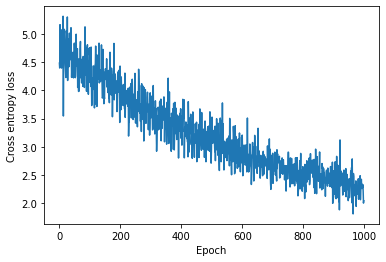

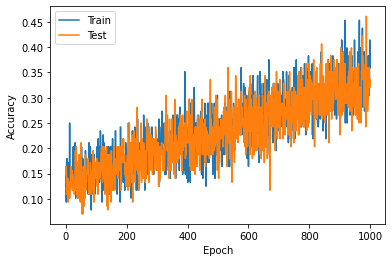

100%|██████████| 1000/1000 [00:32<00:00, 30.75it/s]


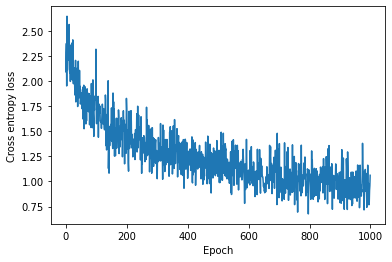

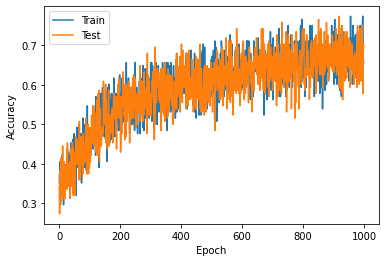

100%|██████████| 1000/1000 [00:36<00:00, 27.38it/s]


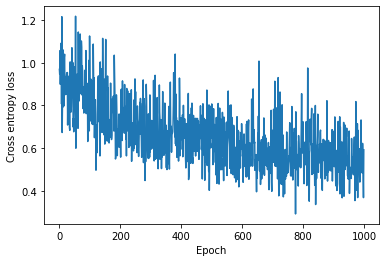

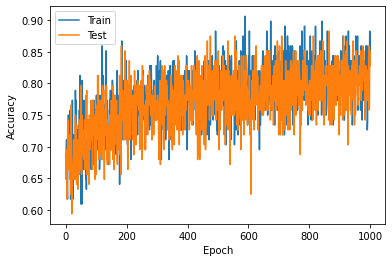

100%|██████████| 1000/1000 [00:33<00:00, 29.85it/s]


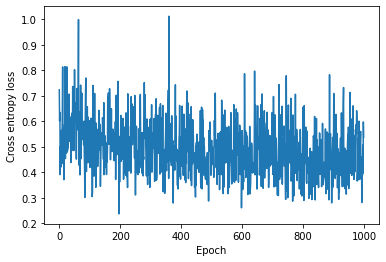

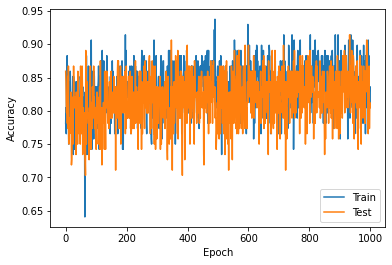

100%|██████████| 1000/1000 [00:32<00:00, 30.37it/s]


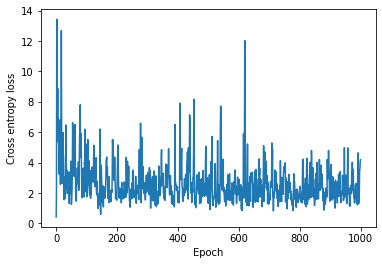

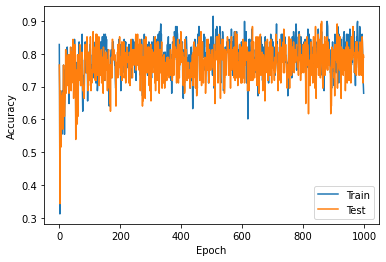

5


<function matplotlib.pyplot.show(*args, **kw)>

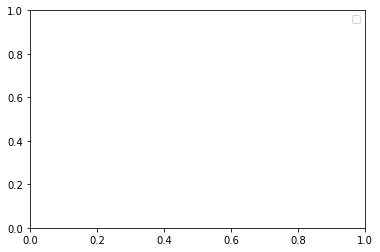

In [ ]:
num_grad_steps = 1000
mlp_opti = MLP(LinearLayer(X_train.shape[-1], 10), SoftmaxOutputLayer(None, None))
best_lr = learning_rate_hyper(mlp_opti, X_train, y_train, X_test, y_test, num_grad_steps)
plt.legend(['lr=1e-4', 'lr=1e-3', 'lr=0.01', 'lr=0.1', 'lr=1'])
plt.savefig("lr-HYPERPARAM", bbox_inches="tight", dpi=300)
plt.show

In [ ]:
print(best_lr)

0.1


# Task 3

# Experiment 1

100%|██████████| 1000/1000 [02:05<00:00,  7.95it/s]


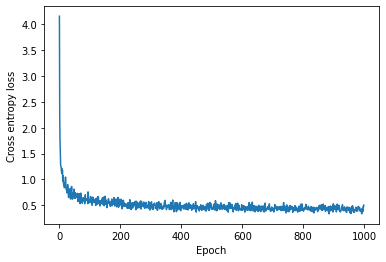

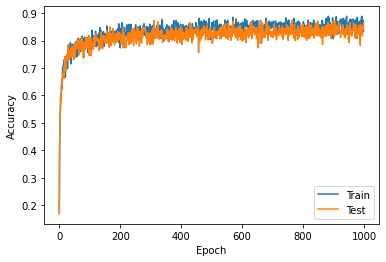

Training Accuracy: 0.8523666666666667
Testing Accuracy: 0.8312


In [ ]:
num_grad_steps = 1000 #EPOCHS

mlp1 = MLP(LinearLayer(X_train.shape[-1], 10), SoftmaxOutputLayer(None, None))

mlp1.fit(best_lr, X_train, y_train, num_grad_steps, 512)

y_hat = mlp1.predict(X_train)
accuracy = mlp1.evaluate_acc(y_train, y_hat)
print("Training Accuracy:", accuracy)

y_hat = mlp1.predict(X_test)
accuracy = mlp1.evaluate_acc(y_test, y_hat)
print("Testing Accuracy:", accuracy)

100%|██████████| 1000/1000 [26:23<00:00,  1.58s/it]


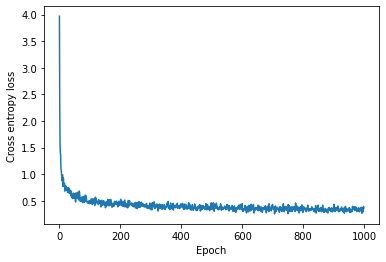

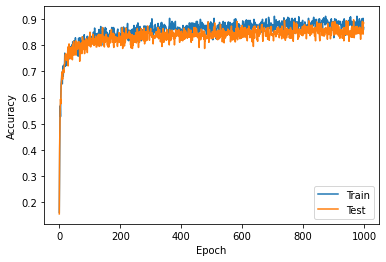

Training Accuracy: 0.8817166666666667
Testing Accuracy: 0.8817166666666667


In [ ]:
hidden_units = 128
num_grad_steps = 1000

mlp2 = MLP(
    LinearLayer(X_train.shape[-1], hidden_units), 
    ReLULayer(None, None), 
    LinearLayer(hidden_units, 10), 
    SoftmaxOutputLayer(None, None)
    )
mlp2.fit(0.1, X_train, y_train, num_grad_steps, 512)

y_hat = mlp2.predict(X_train)
accuracy = mlp2.evaluate_acc(y_train, y_hat)
print("Training Accuracy:", accuracy)

y_hat = mlp2.predict(X_test)
acc = mlp2.evaluate_acc(y_test, y_hat)
print("Testing Accuracy:", accuracy)

In [ ]:
hidden_units = 128
num_grad_steps = 1000

mlp3 = MLP(
    LinearLayer(X_train.shape[-1], hidden_units),
    ReLULayer(None, None),
    LinearLayer(hidden_units, hidden_units),
    ReLULayer(None, None),
    LinearLayer(hidden_units, 10),
    SoftmaxOutputLayer(None, None)
)
mlp3.fit(best_lr, X_train, y_train, num_grad_steps, 512)

y_hat = mlp3.predict(X_train)
accuracy = mlp3.evaluate_acc(y_train, y_hat)
print("Training Accuracy:", accuracy)

y_hat = mlp3.predict(X_test)
accuracy = mlp3.evaluate_acc(y_test, y_hat)
print("Testing Accuracy:", accuracy)

 78%|███████▊  | 784/1000 [24:30<06:52,  1.91s/it]

# Experiment 2

In [ ]:
 #lr Hyperparameter
num_grad_steps = 1000
mlp_opti2 = MLP(
    LinearLayer(X_train.shape[-1], hidden_units),
    TanhLayer(None, None),
    LinearLayer(hidden_units, hidden_units),
    TanhLayer(None, None),
    LinearLayer(hidden_units, 10),
    SoftmaxOutputLayer(None, None)
)
best_lr2 = learning_rate_hyper(mlp_opti2, X_train, y_train, X_test, y_test, num_grad_steps)
plt.legend(['lr=1e-4', 'lr=1e-3', 'lr=0.01', 'lr=0.1', 'lr=1'])
plt.savefig("lr-HYPERPARAM", bbox_inches="tight", dpi=300)
plt.show

In [ ]:
print(best_lr2)

In [ ]:
hidden_units  = 128
num_grad_steps = 1000

mlp4 = MLP(
    LinearLayer(X_train.shape[-1], hidden_units),
    TanhLayer(None, None),
    LinearLayer(hidden_units, hidden_units),
    TanhLayer(None, None),
    LinearLayer(hidden_units, 10),
    SoftmaxOutputLayer(None, None)
)
mlp4.fit(0.1, X_train, y_train, num_grad_steps, 512)

y_hat = mlp4.predict(X_train)
accuracy = mlp4.evaluate_acc(y_train, y_hat)
print("Training Accuracy:", accuracy)

y_hat = mlp4.predict(X_test)
acc = mlp4.evaluate_acc(y_test, y_hat)
print("Testing Accuracy:", accuracy)

In [ ]:
#lr Hyperparameter
num_grad_steps = 1000
mlp_opti3 = MLP(
    LinearLayer(X_train.shape[-1], hidden_units),
    LeakyReLULayer(0.1, None, None),
    LinearLayer(hidden_units, hidden_units),
    LeakyReLULayer(0.1, None, None),
    LinearLayer(hidden_units, 10),
    SoftmaxOutputLayer(None, None)
)
best_lr3 = learning_rate_hyper(mlp_opti2, X_train, y_train, X_test, y_test, num_grad_steps)
plt.legend(['lr=1e-4', 'lr=1e-3', 'lr=0.01', 'lr=0.1', 'lr=1'])
plt.savefig("lr-HYPERPARAM", bbox_inches="tight", dpi=300)
plt.show

In [ ]:
print(best_lr3)

In [ ]:
hidden_units = 128
num_grad_steps = 1000

mlp5 = MLP(
    LinearLayer(X_train.shape[-1], hidden_units),
    LeakyReLULayer(0.1, None, None),
    LinearLayer(hidden_units, hidden_units),
    LeakyReLULayer(0.1, None, None),
    LinearLayer(hidden_units, 10),
    SoftmaxOutputLayer(None, None)
)
mlp5.fit(0.1, X_train, y_train, num_grad_steps, 512)

y_hat = mlp5.predict(X_train)
accuracy = mlp5.evaluate_acc(y_train, y_hat)
print("Training Accuracy:", accuracy)

y_hat = mlp5.predict(X_test)
accuracy = mlp5.evaluate_acc(y_test, y_hat)
print("Testing Accuracy:", accuracy)

# Experiment 3

In [ ]:
hidden_units = 128
num_grad_steps = 500

mlpexp3 = MLP(
    LinearLayer(X_train.shape[-1], hidden_units),
    ReLULayer(None, None),
    LinearLayer(hidden_units, hidden_units),
    ReLULayer(None, None),
    LinearLayer(hidden_units, 10),
    SoftmaxOutputLayer(None, None)
)
mlpexp3.fit_withl2_reg(1e-2, X_train, y_train, num_grad_steps, 512)

y_hat = mlpexp3.predict(X_train)
accuracy = mlpexp3.evaluate_acc(y_train, y_hat)
print("Training Accuracy:", accuracy)

y_hat = mlpexp3.predict(X_test)
accuracy = mlpexp3.evaluate_acc(y_test, y_hat)
print("Testing Accuracy:", accuracy)

# Experiment 4

In [ ]:
hidden_units = 128
num_grad_steps = 1000

mlpexp4 = MLP(
    LinearLayer(X_train_unnorm.shape[-1], hidden_units),
    ReLULayer(),
    LinearLayer(hidden_units, hidden_units),
    ReLULayer(),
    LinearLayer(hidden_units, 10),
    SoftmaxOutputLayer()
)
mlpexp4.fit(0.1, X_train_unnorm, y_train, num_grad_steps, 50)

y_hat = mlpexp4.predict(X_train_unnorm)
accuracy = mlpexp4.evaluate_acc(y_train, y_hat)
print("Training Accuracy:", accuracy)

y_hat = mlpexp4.predict(X_test_unnorm)
accuracy = mlpexp4.evaluate_acc(y_test, y_hat)
print("Testing Accuracy:", accuracy)

# Experiment 5

In [ ]:
#Imports for tensor flow
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D, Dropout, MaxPooling2D, Activation, ZeroPadding2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot

In [ ]:
# Load Fashion MNIST dataset
from keras.datasets import fashion_mnist
(x_train, conv_y_train), (x_test, conv_y_test) = fashion_mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert conv_y_train.shape == (60000,)
assert conv_y_test.shape == (10000,)
CLASS_DESC = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = 10

In [ ]:
train_labels = to_categorical(conv_y_train, num_classes)
test_labels  = to_categorical(conv_y_test, num_classes)

train_images = (x_train / 255)
test_images = (x_test / 255)

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

assert train_images.shape == (60000, 28, 28, 1)
assert test_images.shape == (10000, 28, 28, 1)
assert train_labels.shape == (60000, 10)
assert test_labels.shape == (10000, 10)

In [ ]:
def conv_model(input_shape, num_classes):
  alexnet_conv_model = Sequential()

  #Conv Layer 1
  alexnet_conv_model.add(Conv2D(32, (3,3), input_shape = input_shape, kernel_regularizer = 'l2'))
  alexnet_conv_model.add(BatchNormalization())
  alexnet_conv_model.add(Activation('relu'))

  #Conv Layer 2
  alexnet_conv_model.add(Conv2D(32, (3,3), input_shape = input_shape))
  alexnet_conv_model.add(BatchNormalization())
  alexnet_conv_model.add(Activation('relu'))

  #Flatten
  alexnet_conv_model.add(Flatten())

  #Linear Layer 1
  alexnet_conv_model.add(Dense(128))
  alexnet_conv_model.add(Activation('relu'))

  #Linear Layer 2
  alexnet_conv_model.add(Dense(num_classes))
  alexnet_conv_model.add(Activation('softmax'))

  return alexnet_conv_model

In [ ]:
conv_model = conv_model((28,28,1), 10)
conv_model.summary()

conv_model.compile(loss = tf.losses.categorical_crossentropy , optimizer='sgd', metrics=['accuracy'])

In [ ]:
# Data augmentation (optional: for performance improvement)
datagen = ImageDataGenerator(
  featurewise_center=False,	# set input mean to 0 over dataset
  samplewise_center=False,	# set each sample mean to 0
  featurewise_std_normalization=False,	# divide inputs by std of dataset
  samplewise_std_normalization=False,	#divide each input by its std
  zca_whitening=False,	# apply ZCA whitening
  rotation_range=0,	# randomly roate images in the range (degrees, 0 to 180)
  width_shift_range=0.1,	# randomly shift image horizontally (fraction of width)
  height_shift_range=0.1,	# randomly shift image vertically (fraction of height)
  horizontal_flip=True,	# randomly flip images horizontally
  vertical_flip=False)	# randomly flip images vertically

datagen.fit(train_images)

In [ ]:
epochs = 3

history = conv_model.fit(datagen.flow(train_images, train_labels, batch_size=128), epochs=epochs, verbose = 1, validation_data=(test_images, test_labels))

In [ ]:
plt.clf()
plt.title('Model Accuracies')
plt.plot(history.history['val_accuracy'], label='test', color='red')
plt.plot(history.history['accuracy'], label='train', color='blue')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig("CNN_Accuracies.png")
plt.show()

plt.clf()
plt.title('Model Cross-entropy Loss')
plt.plot(history.history['val_loss'], label='test', color='red')
plt.plot(history.history['loss'], label='train', color='blue')
plt.xlabel("epoch")
plt.ylabel("CE loss")
plt.legend(loc='best')
plt.savefig("CNN_CE_loss.png")
plt.show()

In [ ]:
# Define confusion matrix
def calc_error(predictions, labels):
    """Return the error rate and confusions."""
    correct = np.sum(predictions == labels)
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = np.zeros([10, 10], np.float32)
    bundled = zip(predictions, labels)
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

In [ ]:
# Make predictions for all test images
test_predictions          = np.argmax(conv_model.predict(test_images),1)
test_error, test_conf_mat = calc_error(test_predictions, np.argmax(test_labels,1))
print('Test error: %.1f%%' % test_error)

plt.figure(figsize=(6, 6))
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(np.arange(num_classes))
plt.yticks(np.arange(num_classes))
plt.imshow(test_conf_mat, cmap=plt.cm.jet, interpolation='nearest');

for i, cas in enumerate(test_conf_mat):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')

plt.savefig("Confusion_Matrix_CNN.png")

# Experiment 6

In [ ]:
hidden_units  = 128
num_grad_steps = 2000

mlp8 = MLP(
    LinearLayer(X_train.shape[-1], hidden_units),
    TanhLayer(None, None),
    LinearLayer(hidden_units, hidden_units),
    TanhLayer(None, None),
    LinearLayer(hidden_units, 10),
    SoftmaxOutputLayer(None, None)
)
mlp8.fit(0.1, X_train, y_train, num_grad_steps, 512)

y_hat = mlp8.predict(X_train)
accuracy = mlp8.evaluate_acc(y_train, y_hat)
print("Training Accuracy:", accuracy)

y_hat = mlp8.predict(X_test)
acc = mlp8.evaluate_acc(y_test, y_hat)
print("Testing Accuracy:", accuracy)

# Beyond minimum requirement


100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


Training Accuracy: 0.7654333333333333
Testing Accuracy: 0.759


100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Training Accuracy: 0.7938
Testing Accuracy: 0.7809


100%|██████████| 100/100 [00:18<00:00,  5.30it/s]


Training Accuracy: 0.7963166666666667
Testing Accuracy: 0.7865


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Training Accuracy: 0.7230833333333333
Testing Accuracy: 0.7139


100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


Training Accuracy: 0.7984166666666667
Testing Accuracy: 0.7866


100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


Training Accuracy: 0.7963
Testing Accuracy: 0.7874


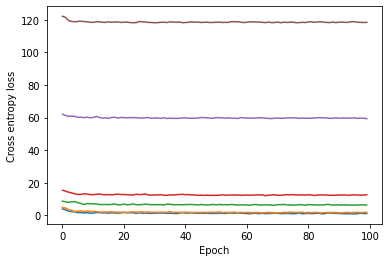

In [ ]:
hidden_units = 128
num_grad_steps = 100

grad_step = np.linspace(0, num_grad_steps, 10)
alpha_l2_reg = np.array([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])
accuracy = np.full((len(alpha_l2_reg), 2), 0.0)
for ia in range(len(alpha_l2_reg)):
  mlpexpb = MLP(
    LinearLayer(X_train.shape[-1], hidden_units),
    ReLULayer(),
    LinearLayer(hidden_units, hidden_units),
    ReLULayer(),
    LinearLayer(hidden_units, 10),
    SoftmaxOutputLayer()
  )

  mlpexpb.fit_withl2_reg(0.1, X_train, y_train, 100, 50, alpha_l2_reg[ia])

  y_hat = mlpexpb.predict(X_train)
  accuracy[ia, 0] = mlpexp3.evaluate_acc(y_train, y_hat)
  print("Training Accuracy:", accuracy[ia, 0])

  y_hat = mlpexpb.predict(X_test)
  accuracy[ia, 1] = mlpexp3.evaluate_acc(y_test, y_hat)
  print("Testing Accuracy:", accuracy[ia, 1])


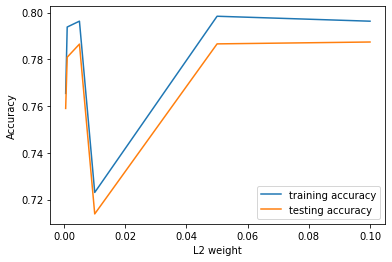

In [ ]:

fig = plt.figure()
plt.plot(alpha_l2_reg, accuracy[:, 0], label='training accuracy')
plt.plot(alpha_l2_reg, accuracy[:, 1], label='testing accuracy')
plt.xlabel('L2 weight')
plt.ylabel('Accuracy')
plt.legend()
plt.show()